In [7]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.Pipelines.skypy_pipeline import SkyPyPipeline
from astropy.modeling.models import Linear1D, Exponential1D
import numpy as np
from skypy.galaxies import schechter_lf
from astropy.table import vstack, Table

## Define a cosmology and sky area

In [2]:
# define a cosmology
cosmology = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = Quantity(value=1, unit="deg2")

## Plot Schechter functions

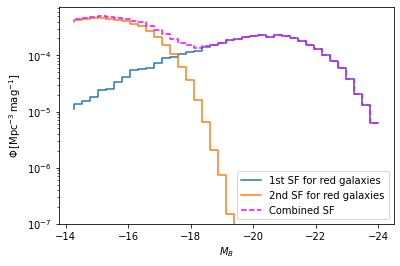

In [3]:
z_range = np.linspace(0.0, 3.01, 100)
## These are the parameters used in the lsst-like_new.yml file for 1st schechter
# function for red galaxies.
m_star = Linear1D(-0.80, -20.46)
phi_star = Exponential1D(0.00278612, -1.05925)
alpha, mag_lim = -0.53, 30
redshift, magnitude = schechter_lf(
    z_range, m_star, phi_star, alpha, mag_lim, sky_area, cosmology, noise=True
)

## These are the parameters used in the lsst-like_new.yml file for 2st schechter
# function for red galaxies.
m_star2 = -17
phi_star2 = Exponential1D(0.00278612, -1.05925)
alpha2, mag_lim2 = -1.31, 30
redshift2, magnitude2 = schechter_lf(
    z_range, m_star2, phi_star2, alpha2, mag_lim2, sky_area, cosmology, noise=True
)


# magnitude bins
bins = np.linspace(-24, -14, 40)
z_min = z_range[0]
z_max = z_range[-1]
# Redshift grid
z = np.linspace(z_min, z_max, 200)

# SkyPy simulated galaxies

# 1st schechter function
z_mask = np.logical_and(redshift >= z_min, redshift < z_max)
dV_dz = (cosmology.differential_comoving_volume(z) * sky_area).to_value("Mpc3")
dV = np.trapz(dV_dz, z)
dM = (np.max(bins) - np.min(bins)) / (np.size(bins) - 1)
phi_first_red = np.histogram(magnitude[z_mask], bins=bins)[0] / dV / dM

# 2nd schechter function
z_mask2 = np.logical_and(redshift2 >= z_min, redshift2 < z_max)
dV_dz2 = (cosmology.differential_comoving_volume(z) * sky_area).to_value("Mpc3")
dV2 = np.trapz(dV_dz2, z)
dM2 = (np.max(bins) - np.min(bins)) / (np.size(bins) - 1)
phi_second_red = np.histogram(magnitude2[z_mask2], bins=bins)[0] / dV2 / dM2

# combined schechterfunction
redshift3 = np.concatenate((redshift, redshift2))
magnitude3 = np.concatenate((magnitude, magnitude2))
z_mask3 = np.logical_and(redshift3 >= z_min, redshift3 < z_max)
dV_dz3 = (cosmology.differential_comoving_volume(z) * sky_area).to_value("Mpc3")
dV3 = np.trapz(dV_dz3, z)
dM3 = (np.max(bins) - np.min(bins)) / (np.size(bins) - 1)
phi_combined_red = np.histogram(magnitude3[z_mask3], bins=bins)[0] / dV3 / dM3


# Plotting
plt.step(bins[:-1], phi_first_red, where="post", label="1st SF for red galaxies")
plt.step(bins[:-1], phi_second_red, where="post", label="2nd SF for red galaxies")
plt.step(
    bins[:-1],
    phi_combined_red,
    where="post",
    label="Combined SF",
    ls="--",
    color="magenta",
)

plt.xlabel(r"$M_B$")
plt.ylabel(r"$\Phi \, [\mathrm{Mpc}^{-3} \, \mathrm{mag}^{-1}]$")
plt.yscale("log")
# plt.xlim([-14, -24])
# plt.ylim([3e-7, 3e-2])
plt.gca().invert_xaxis()

plt.legend(loc="lower right")
plt.show()

## Get galaxy distribution from SkyPyPipeline

In [12]:
## For the red galaxies, this configuration uses combined Schechter
# function (magenta curve in above plot).
pipeline_double = SkyPyPipeline(
    skypy_config="lsst_like_new", sky_area=None, filters=None, cosmo=cosmology
)
## For the red galaxies, this configuration uses single Schechter
# function (blue curve in above plot).
pipeline_single = SkyPyPipeline(
    skypy_config="lsst_like_old", sky_area=None, filters=None, cosmo=cosmology
)

In [13]:
## Let's draw red galaxies from these two different Schechter function.
red_galaxies_double = pipeline_double.red_galaxies
red_galaxies_single = pipeline_single.red_galaxies

In [14]:
# These are all galaxies from from two cases.
single_total = vstack([pipeline_single.red_galaxies, pipeline_single.blue_galaxies])
double_total = vstack([pipeline_double.red_galaxies, pipeline_double.blue_galaxies])

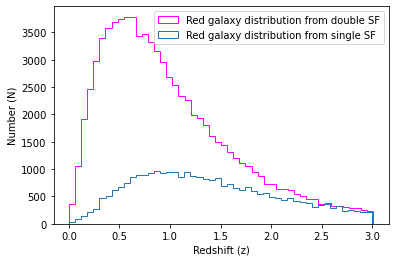

In [15]:
## Plot red galaxy distributions from single Schechter function and double Schcheter
# functions.
plt.hist(
    red_galaxies_double["z"],
    bins=50,
    histtype="step",
    label="Red galaxy distribution from double SF",
    color="magenta",
)
plt.hist(
    red_galaxies_single["z"],
    bins=50,
    histtype="step",
    label="Red galaxy distribution from single SF",
)
plt.xlabel("Redshift (z)")
plt.ylabel("Number (N)")
plt.legend()

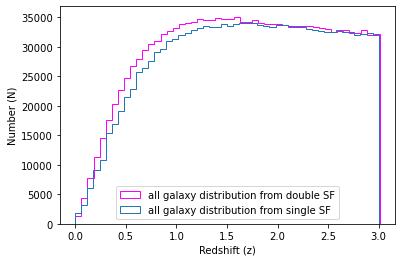

In [17]:
plt.hist(
    double_total["z"],
    bins=50,
    density=False,
    histtype="step",
    label="all galaxy distribution from double SF",
    color="magenta",
)
plt.hist(
    single_total["z"],
    bins=50,
    density=False,
    histtype="step",
    label="all galaxy distribution from single SF",
)
"""plt.hist(dc2_galaxies["redshift_true"], bins=50, density=True, histtype="step",
            label="DC2 galaxy distribution")"""
plt.xlabel("Redshift (z)")
plt.ylabel("Number (N)")
plt.legend(loc="lower center")